In [1]:
import h5py

In [2]:
import matplotlib.pyplot as plt

% matplotlib inline

In [4]:
from glob import glob
from scipy import misc 

def load_data():
    return [ misc.imread(i) for i in glob("./svhn/train/*.png") ]

In [6]:
images = load_data()

In [3]:
import operator

import PIL.Image
import PIL.ImageDraw
import os

In [4]:
import numpy as np

In [83]:
index = 15720

In [5]:
class MatReader:
    def __init__(self, filepath):
        self.f = h5py.File(filepath)

    def get_name(self, index):
        f = self.f
        ref = f.get("/digitStruct/name").value[index][0]
        filename = "".join( map(chr, map( operator.itemgetter(0), f[ref].value) ) )
        return filename
        
    def get_bbox(self, index):
        f = self.f
        
        ref = f.get("/digitStruct/bbox")
        res = f[ ref.value[index][0] ]
        
        d = {}
        
        for k,v in dict(res).items():
            if v.shape[0] > 1:
                values = np.array([ f[item[0]].value[0][0] for item in v ], dtype=np.int)
            else:
                values = np.array( [ v.value[0][0], ] , dtype=np.int)
            #print("{} => {}".format(k, values))
            d[k] = values
        d["label"] = [ 0 if label == 10 else label for label in d["label"] ]
        return d
    
    def get(self, index):
        filename = self.get_name(index)
        bbox = self.get_bbox(index)
        fullpath = os.path.join("./svhn/train", filename)
        
        image = PIL.Image.open(fullpath)
        
        draw = PIL.ImageDraw.Draw(image)

        for i in range(len(bbox['label'])):
            x0 = bbox['left'][i]
            y0 = bbox['top'][i]
            x1 = x0 + bbox['width'][i]
            y1 = y0 + bbox['height'][i]

            draw.rectangle([x0, y0, x1, y1])
        
        #Image(image)
        return image#, bbox
    
#     def get_cliped_bbox(self, index):
#         bbox = self.get_bbox(index)
#         width = height = 0
#         size= len(bbox['label'])
#         x1 = np.min(bbox['left']) #bbox['left'][0] #np.mean( [ left for left in bbox['left'] ] )
#         y1 = np.min( bbox['top'] )
#         width = (bbox['left'][size-1] + bbox['width'][size-1]) - bbox['left'][0]
#         height = np.max( [ left for left in bbox['height'] ] )
#         label = "".join(list(map(str, map(int, bbox["label"]))))        
#         return (left, top, width, height), label

    def get_clipped_bbox(self, index):
        bbox = self.get_bbox(index)
        x1 = bbox['left'].min()
        y1 = bbox['top'].min()
        x2 = (bbox['left'] + bbox['width']).max()
        y2 = (bbox['top'] + bbox['height']).max()
        label = "".join(list(map(str, map(int, bbox["label"]))))
        return (x1, y1), (x2, y2)

    
    def clip(self, index):
        filename = self.get_name(index)
        fullpath = os.path.join("./svhn/train", filename)
        image = PIL.Image.open(fullpath)
        draw = PIL.ImageDraw.Draw(image)
        (x0,y0, width, height), label = self.get_cliped_bbox(index)
        draw.rectangle([x0, y0, x0 + width, y0 + height])
        
        #print([x0, y0, x0 + width, y0 + height])
        #return image
        return image.crop((x0, y0, x0 + width, y0 + height)).resize((32,32)), label
    

In [6]:
reader = MatReader("./svhn/train/digitStruct.mat")

In [7]:
reader.get(34)

In [8]:
reader.get(4266)

45


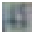

In [9]:
img, label = reader.clip(4266)
print(label)
img

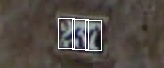

In [10]:
reader.get(8132)

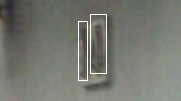

In [23]:
reader.get(7154)

14


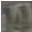

In [18]:
img, label = reader.clip(7154)
print(label)
img

In [31]:
bbox = reader.get_bbox(7154)
bbox

{'height': [59.0, 59.0],
 'label': [1.0, 4.0],
 'left': [78.0, 90.0],
 'top': [21.0, 14.0],
 'width': [9.0, 16.0]}

In [40]:
x1 = np.min(bbox['left'])
y1 = np.min(bbox['top'])
x2 = np.max( np.array(bbox['left']) + np.array(bbox['width']) )
y2 = np.max( np.array(bbox['top']) + np.array(bbox['height']) )
(x1, y1), (x2, y2)

((78.0, 14.0), (106.0, 80.0))

In [38]:
np.max( np.array(bbox['top']) + np.array(bbox['height']) )

80.0

78 14 106 73


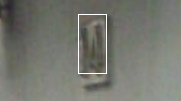

In [30]:
index = 7154
filename = reader.get_name(index)
fullpath = os.path.join("./svhn/train", filename)
image = PIL.Image.open(fullpath)
draw = PIL.ImageDraw.Draw(image)
#(x0,y0, width, height), label = self.get_cliped_bbox(index)
x0, y0, width, height = 78, 14, 28, 59
print(x0, y0, x0+width, y0+height)
draw.rectangle([x0, y0, x0 + width, y0 + height])
image

785 is 72


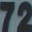

In [15]:
rint = np.random.randint(10000)
#rint = 4618
img, label = reader.clip(rint)
print("{} is {}".format(rint, label))
img

In [121]:
! mkdir ./svhn/train_preprocessed/

In [16]:
from keras.preprocessing.image import img_to_array, array_to_img

Using TensorFlow backend.


In [17]:
# preprocess image
labels = []
x = []
for i, filepath in enumerate(glob("./svhn/test/*.png")):
    img, label = reader.clip(i)
    labels.append(label)
    x.append(img_to_array(img))
    #filename = os.path.basename(filepath)
    #img.save("./svhn/train_preprocessed/{}".format(filename))
    if i % 1000 == 0:
        print(".", end="")

#y = np.array(labels)
np.save("./svhn/test_preprocessed_labels.npy", labels)
np.save("./svhn/test_preprocessed_img.npy", x)

..............

In [218]:
np.save("./svhn/train_preprocessed_labels.npy", labels)
np.save("./svhn/train_preprocessed_img.npy", x)

In [220]:
x = np.load("./svhn/train_preprocessed_img.npy")
x.shape

(33402, 32, 32, 3)

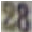

In [224]:
array_to_img(x[6])